# Growth Limiation - Create a grid of factor most limiting growth at each year for summer months, for each phytoplankton group... throuhout the whole Arctic Ocean. 
1. find what areas around the Arctic are limited by what, and 
2. see how you can plot difference plots or show how these differ between high and low temp, ice and NO$_3$ years. 

In [1]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
#import hvplot.xarray
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy

In [2]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

## Check what these files are, because they could save a lot of time... 

In [5]:
diat3 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_limitation.nc')
pp = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/pp_limitation.nc')
diat2 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat2_limitation.nc')
diat1 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat1_limitation.nc')
mp1 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp1_limitation.nc')
mp2 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp2_limitation.nc')
mp3 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp3_limitation.nc')
mp4 = xr.open_mfdataset('/glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp4_limitation.nc')

	NC4_open: path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_limitation.nc mode 4096 params 0
	HDF5 error messages turned on.
			nc4_open_file: path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_limitation.nc mode 4096
			nc4_grp_list_add: name / 
			nc4_rec_read_metadata: grp->hdr.name /
			found dataset month
			found dataset nlat
			found dataset nlon
			found dataset TLONG
			found dataset TLAT
			found dataset time
			found dataset diat3_lim_value
			found dataset diat3_lim_index
ERROR: Invalid _NCProperties attribute
		*** NetCDF-4 Internal Metadata: int_ncid 0xd0000 ext_ncid 0xd0000
		FILE - path: /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/diat3_limitation.nc cmode: 0x1008 parallel: 0 redef: 0 fill_mode: 0 no_write: 1 next_nc_grpid: 1
		 GROUP - / nc_grpid: 0 nvars: 6 natts: 0
		 DIMENSION - dimid: 0 name: month len: 12 unlimited: 0
		 DIMENSION - dimid: 1 name: nlat len: 384 unlimited: 0
		 DIMENSION - dimid: 2 name: nlon len: 320 unlimited: 0
		 DIMENSION - 

## Set up colorbar

In [6]:
# colors for each variable 
# temperature (Blue)
temperature3 = ''
temperature2        = '#e0f3f8'
temperature1       = '#abd9e9'
temperature       = '#74add1'
# light (yellow)
light   = '#fdae61'
light1   ='#fee090'
light2   ='#ffffbf'
light3=''
# nutrients (Green)
nitrate2     = '#AFE1AF'
nitrate1     ='#00A36C'
nitrate     ='#097969'

from matplotlib.colors import LinearSegmentedColormap
color_temp = [temperature,temperature1,temperature2]
color_light = [light,light1,light2]
color_nutrients = [nitrate,nitrate1,nitrate2]

cmap_name = 'my_list'
cm_temp = LinearSegmentedColormap.from_list(
        cmap_name, color_temp, N=3)
cm_light = LinearSegmentedColormap.from_list(
        cmap_name, color_light, N=3)
cm_nutrients = LinearSegmentedColormap.from_list(
        cmap_name, color_nutrients, N=3)

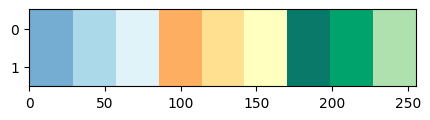

In [7]:
N = 3 # number of colors to extract from each of the base_cmaps below
phyto = [cm_temp,cm_light,cm_nutrients]

n_base = len(phyto)
# we go from 0.2 to 0.8 below to avoid having several whites and blacks in the resulting cmaps
colors_phyto = np.concatenate([plt.get_cmap(name)(np.linspace(0,1,N)) for name in phyto])
cm_phyto = mpl.colors.ListedColormap(colors_phyto)

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))

fig, ax = plt.subplots(1,1,figsize=(5,1))
ax.imshow(gradient, aspect='auto', cmap=cm_phyto)

## Plot the regional limitaiton during the summer to make sure these are working correctly! 

		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
			NC4_get_vars: var->hdr.name pp_lim_value mem_nc_type 6
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_

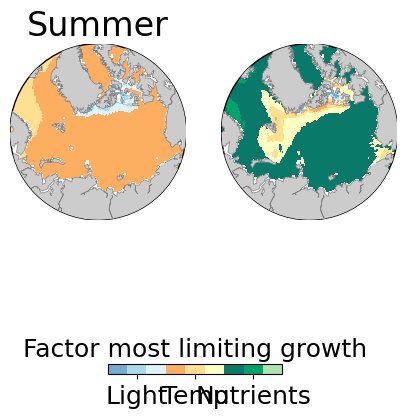

CPU times: user 3.99 s, sys: 7.05 s, total: 11 s
Wall time: 18.2 s


<Figure size 640x480 with 0 Axes>

In [8]:
%%time
fig = plt.figure(figsize=(5,5))
# ------------------------- Picoplankton ---------------------------
# Summer
ax = fig.add_subplot(121) 
ax.set_title("Summer",fontsize=24)
pp_lims = (pp.pp_lim_value.where(pp.pp_lim_value < 0.9) + pp.pp_lim_index.where(pp.pp_lim_value < 0.9))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(pp_lims[:,5:8,:,:], axis=(0,1)))
x, y = m(tlon,tlat)
cf = m.pcolormesh(x,y,summer,cmap=cm_phyto, vmin=0, vmax=3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)

# Summer
ax = fig.add_subplot(122) 
diat3_lims = (diat3.diat3_lim_value.where(diat3.diat3_lim_value < 0.9) + diat3.diat3_lim_index.where(diat3.diat3_lim_value < 0.9))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
tlon, tlat, summer = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(diat3_lims[:,5:8,:,:], axis=(0,1)))
x, y = m(tlon,tlat)
cff = m.pcolormesh(x,y,summer,cmap=cm_phyto, vmin=0, vmax=3)
m.drawcoastlines(linewidth=0.5, linestyle='solid', color='gray', antialiased=1, ax=None, zorder=None)
m.fillcontinents(color='0.8', lake_color=None, ax=None, zorder=None, alpha=None)

cbar_ax = fig.add_axes([0.32, 0.01, 0.35, 0.02])
cbar = fig.colorbar(cf, cax=cbar_ax, shrink=0.75, spacing='uniform',ticks=[0.5,1.5,2.5],orientation="horizontal")
cbar.ax.set_xticklabels(['Light','Temp', 'Nutrients'], fontsize = 18)
cbar.ax.set_title('Factor most limiting growth', fontsize = 18)
m.plot
plt.show()
plt.tight_layout()

In [9]:
%%time
pp_lims = (pp.pp_lim_value.where(pp.pp_lim_value < 0.9) + pp.pp_lim_index.where(pp.pp_lim_value < 0.9))
mp1_lims = (mp1.mp1_lim_value.where(mp1.mp1_lim_value < 0.9) + mp1.mp1_lim_index.where(mp1.mp1_lim_value < 0.9))
mp2_lims = (mp2.mp2_lim_value.where(mp2.mp2_lim_value < 0.9) + mp2.mp2_lim_index.where(mp2.mp2_lim_value < 0.9))
mp3_lims = (mp3.mp3_lim_value.where(mp3.mp3_lim_value < 0.9) + mp3.mp3_lim_index.where(mp3.mp3_lim_value < 0.9))
mp4_lims = (mp4.mp4_lim_value.where(mp4.mp4_lim_value < 0.9) + mp4.mp4_lim_index.where(mp4.mp4_lim_value < 0.9))
diat1_lims = (diat1.diat1_lim_value.where(diat1.diat1_lim_value < 0.9) + diat1.diat1_lim_index.where(diat1.diat1_lim_value < 0.9))
diat2_lims = (diat2.diat2_lim_value.where(diat2.diat2_lim_value < 0.9) + diat2.diat2_lim_index.where(diat2.diat2_lim_value < 0.9))
diat3_lims = (diat3.diat3_lim_value.where(diat3.diat3_lim_value < 0.9) + diat3.diat3_lim_index.where(diat3.diat3_lim_value < 0.9))

CPU times: user 71.1 ms, sys: 2.45 ms, total: 73.6 ms
Wall time: 250 ms


In [10]:
%%time
phyto_lims = np.stack([np.nanmean(pp_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat1_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat2_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(diat3_lims[:,5:8,:,:],axis=1),
                       np.nanmean(mp4_lims[:,5:8,:,:],axis=1)
                      ],axis=0)

		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_dim: ncid 0xe0000 dimid 1
		NC4_inq_dim: ncid 0xe0000 dimid 0
		NC4_inq_dim: ncid 0xe0000 dimid 2
		NC4_inq_dim: ncid 0xe0000 dimid 3
		NC4_inq_var_all: ncid 0xe0000 varid 4
			NC4_get_vars: var->hdr.name pp_lim_value mem_nc_type 6
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_inq_var_all: ncid 0xe0000 varid 4
		NC4_

CPU times: user 6.65 s, sys: 19.3 s, total: 25.9 s
Wall time: 34 s


## Mask the Region of the Arctic Ocean that you want to average through

In [11]:
%%time
# Make the latitude an numpy array 
lat = np.array(ds.TLAT[:,0])

# Select latitudes above 65 degrees 
lat_mask=[(lat>=65)] 
lat_masked=lat[lat_mask] 

# obtain shapes of biomass arrays
b,c,m,n = phyto_lims.shape

# Mask biomass arrays 
phyto_lims_masked = phyto_lims[:,:,np.arange(m)[lat_mask][:, None], :]

CPU times: user 33.9 ms, sys: 202 ms, total: 236 ms
Wall time: 875 ms


## Create colormap with three different colors, representing temperature, light and nutrients. 

In [12]:
from matplotlib.colors import LinearSegmentedColormap
colors = [(0.9994925028835063, 0.9192618223760093, 0.6061361014994233),(0.45066769191336664, 0.7509983339741125, 0.7703857490708702),(0.6825187635707243, 0.810691907283208, 0.6352470180118206)]

cmap_name = 'my_list'
cm = LinearSegmentedColormap.from_list(
        cmap_name, colors, N=3)

## Create grid, with phytoplankton types in the y axis, and years in the x axis, that are color coded with the most limiting factor. 

In [18]:
years = ['1948','1949','1950','1951','1952','1953','1954','1955','1956','1957','1958','1959',
         "1960",'1961','1962','1963','1964','1965','1966','1967','1968','1969',
         "1970",'1971','1972','1973','1974','1975','1976','1977','1978','1979',
         "1980",'1981','1982','1983','1984','1985','1986','1987','1988','1989',
         "1990",'1991','1992','1993','1994','1995','1996','1997','1998','1999',
         '2000','2001','2002','2003','2004','2005','2006','2007','2008','2009']

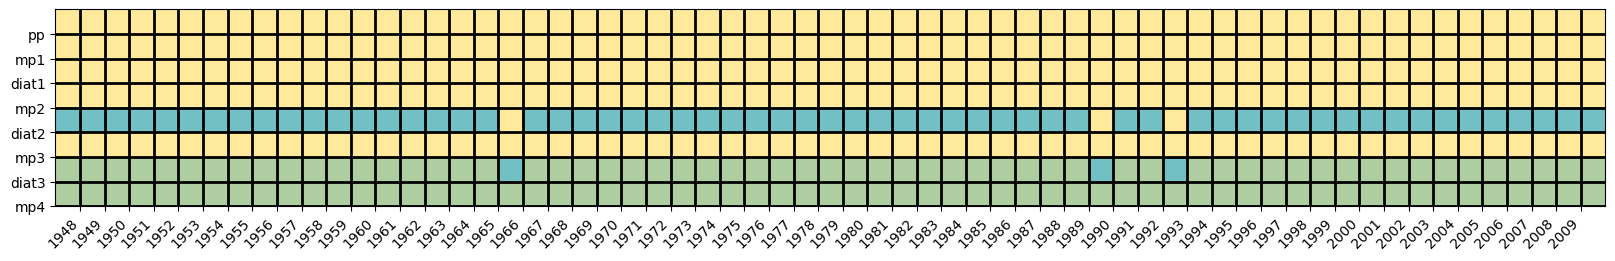

In [19]:
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy as np

data =  np.nanmean(phyto_lims_masked,axis=(2,3,4))# Should be 9 by 63... 
fig, ax = plt.subplots(figsize=(20,5))
ax.imshow(data, cmap=cm)

# draw gridlines
ax.grid(which='major', axis='both', linestyle='-', color='k', linewidth=2)
ax.set_xticks(np.arange(0.5, 62, 1));
ax.set_xticklabels(years,rotation=45, ha="right")
ax.set_yticks(np.arange(0.5, 8, 1));
ax.set_yticklabels(['pp','mp1','diat1','mp2','diat2','mp3','diat3','mp4'])

plt.show()

## Now plot out all of the anomalies

In [20]:
%%time
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 675 ms, sys: 374 ms, total: 1.05 s
Wall time: 32.7 s


In [21]:
%%time
temp_ds_inter = np.empty([63,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    temp_ds_inter[i,:,:,:] = ds.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 11.7 s, sys: 16.2 s, total: 27.9 s
Wall time: 48.6 s


In [22]:
%%time
temp_ao = np.nanmean(temp_ds_inter[:,:,170:180,:], axis=(2,3))
temp_ao_anom = temp_ao-np.nanmean(temp_ao,axis=0)
err_ao = np.nanstd(temp_ao_anom,axis=(0,1))

CPU times: user 25.8 ms, sys: 65.1 ms, total: 90.9 ms
Wall time: 7.69 s


In [23]:
%%time
temp_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds= xr.open_mfdataset(temp_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

	NC4_close: ncid 0xe0000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/pp_limitation.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639700
			closing HDF5 dataset 360287970189639703
			closing HDF5 dataset 360287970189639704
			closing HDF5 dataset 360287970189639707
			closing HDF5 dataset 360287970189639710
			closing HDF5 dataset 360287970189639715
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/pp_limitation.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name NCO 
			att_free: name history 
			att_free: name units 
			att_free: name calendar 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name coordinates 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: na

CPU times: user 469 ms, sys: 112 ms, total: 581 ms
Wall time: 4.76 s


	NC4_close: ncid 0x130000
			nc4_close_hdf5_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp3_limitation.nc abort 0
			nc4_rec_grp_HDF5_del: grp->name /
			closing HDF5 dataset 360287970189639800
			closing HDF5 dataset 360287970189639803
			closing HDF5 dataset 360287970189639804
			closing HDF5 dataset 360287970189639807
			closing HDF5 dataset 360287970189639810
			closing HDF5 dataset 360287970189639815
			nc4_close_netcdf4_file: h5->path /glade/u/home/gabyn/scratch/SPECTRA/growth_lim/mp3_limitation.nc abort 0
			nc4_rec_grp_del: grp->name /
			att_free: name NCO 
			att_free: name history 
			att_free: name units 
			att_free: name calendar 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name units 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free: name coordinates 
			att_free: name _FillValue 
			att_free: name long_name 
			att_free:

In [24]:
%%time
ECOSYS_IFRAC_ds_inter = np.empty([63,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

CPU times: user 591 ms, sys: 217 ms, total: 808 ms
Wall time: 2.47 s


In [25]:
%%time
ECOSYS_IFRAC_ao = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,170:180,:], axis=(2,3))
ECOSYS_IFRAC_ao_anom = ECOSYS_IFRAC_ao-np.nanmean(ECOSYS_IFRAC_ao,axis=0)

CPU times: user 12.1 ms, sys: 5.11 ms, total: 17.2 ms
Wall time: 104 ms


In [26]:
%%time
NO3_inds = sorted(glob.glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds= xr.open_mfdataset(NO3_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

CPU times: user 563 ms, sys: 330 ms, total: 894 ms
Wall time: 19.8 s


In [27]:
%%time
NO3_ds_inter = np.empty([63,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,756,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(63):
    NO3_ds_inter[i,:,:,:] = ds.NO3[x[i]:x[i]+12,0,:,:]

CPU times: user 11.5 s, sys: 16.9 s, total: 28.3 s
Wall time: 1min 7s


In [28]:
%%time
NO3_ao = np.nanmean(NO3_ds_inter[:,:,170:180,:], axis=(2,3))
NO3_ao_anom = NO3_ao-np.nanmean(NO3_ao,axis=0)

CPU times: user 20.8 ms, sys: 25.8 ms, total: 46.6 ms
Wall time: 1.82 s


In [29]:
NO3_ao_anom.shape

(63, 12)

(-0.5, 0.5)

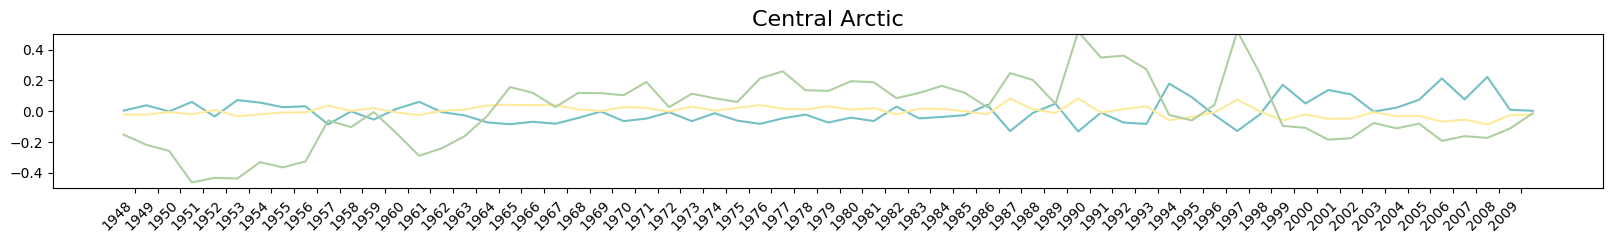

In [34]:
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.gridspec import GridSpec

cmap= matplotlib.cm.get_cmap('Reds', 10)
cmap1= matplotlib.cm.get_cmap('Blues', 10)

fig = plt.figure(figsize=(20, 2))

# Subplot 1
ax1 = fig.add_subplot(1,1,1);
ax1.plot(np.nanmean(temp_ao_anom,axis=1),color=cm(1))
ax1.plot(np.nanmean(ECOSYS_IFRAC_ao_anom,axis=1),color=cm(0))
ax1.plot(np.nanmean(NO3_ao_anom,axis=1), color=cm(2))
ax1.set_title('Central Arctic', fontsize=16)
ax1.set_xticks(np.arange(0.5, 62, 1));
ax1.set_xticklabels(years,rotation=45, ha="right")
ax1.set_ylim(-0.5,0.5)